In [14]:
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt

In [34]:
"""
create commit frequency dataset
"""

commits = pd.read_csv("data/commits.csv")
commits["timestamp"] = pd.to_datetime(commits["timestamp"], unit="s")
commits_grouped = commits.groupby(["project", "timestamp"]).count()
commits_grouped = commits_grouped.reset_index()
commits_grouped = commits_grouped.set_index("timestamp")

projects = sorted(commits_grouped["project"].unique())

combined = DataFrame()
for project in projects:
    # set resolution of 2 weeks
    frequency = commits_grouped[commits_grouped["project"] == project].resample("14d").sum()
    frequency = frequency.rename(columns={"commit_hash": "commits_per_14days"})
    frequency["project"] = project
    combined = pd.concat([combined, frequency])

combined.to_csv("data/commit_frequency_14d.csv")



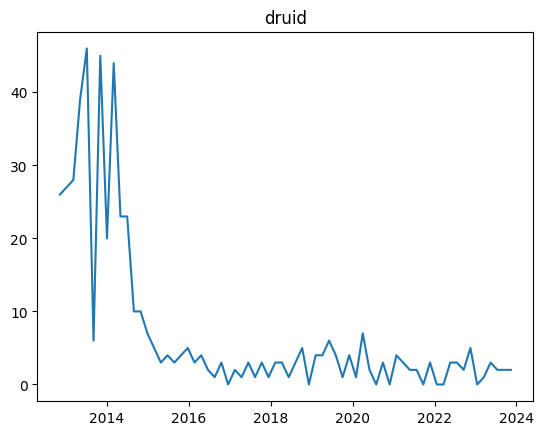

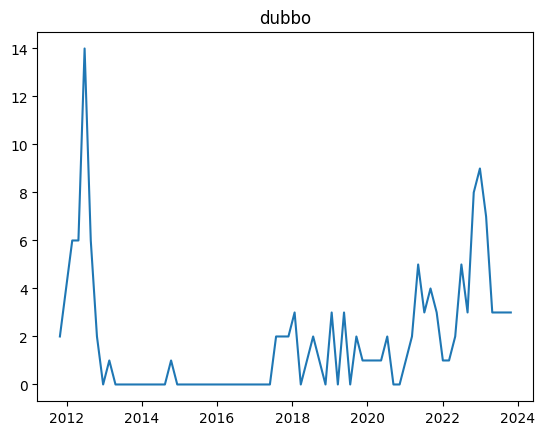

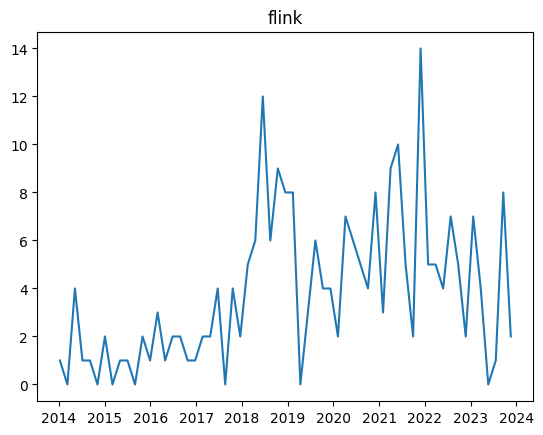

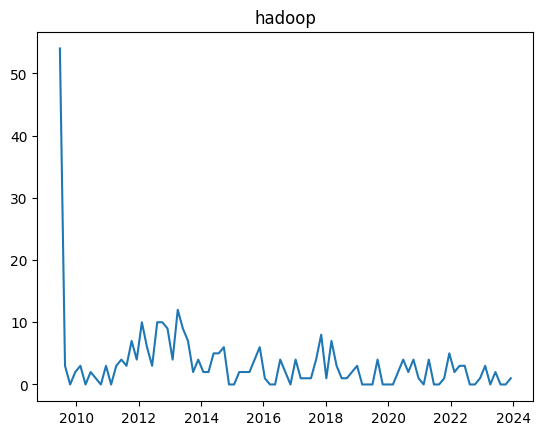

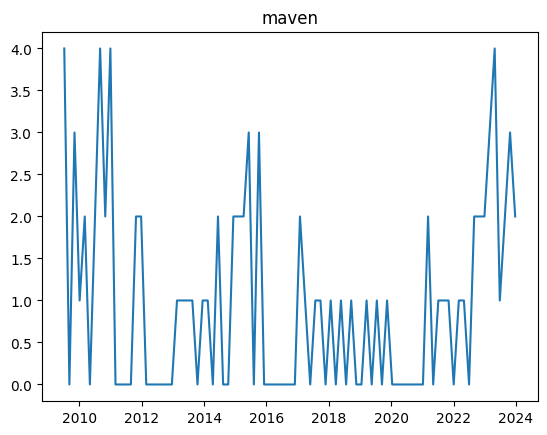

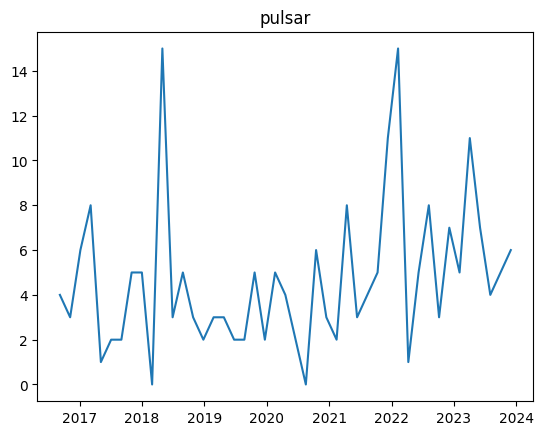

In [36]:
from pandas import DataFrame

"""
create release frequency dataset
"""

commits = pd.read_csv("data/releases.csv")
commits["timestamp"] = pd.to_datetime(commits["timestamp"], unit="s")
commits_grouped = commits.groupby(["project", "timestamp"]).count()
commits_grouped = commits_grouped.reset_index()
commits_grouped = commits_grouped.set_index("timestamp")

projects = sorted(commits_grouped["project"].unique())
combined = DataFrame()

for project in projects:
    # set resolution of 2 weeks
    frequency = commits_grouped[commits_grouped["project"] == project].resample("60d").sum()
    frequency = frequency.rename(columns={"release_name": "releases_per_60days"})
    frequency["project"] = project
    combined = pd.concat([combined, frequency])
    frequency.reset_index(inplace=True)
    plt.plot(frequency["timestamp"], frequency["releases_per_60days"])
    plt.title(project)
    plt.show()

combined.to_csv("data/release_frequency_60d.csv")

In [42]:
"""
merge all to master dataset
"""

satds = pd.read_csv("data/satds.csv")

satds["total"] = satds["code|design-debt"] + satds["test-debt"] + satds["documentation-debt"] + satds[
    "requirement-debt"]

commit_frequency = pd.read_csv("data/commit_frequency_14d.csv")
release_frequency = pd.read_csv("data/release_frequency_60d.csv")

satds["timestamp"] = pd.to_datetime(satds["timestamp"], unit="s")
commit_frequency["timestamp"] = pd.to_datetime(commit_frequency["timestamp"])
release_frequency["timestamp"] = pd.to_datetime(release_frequency["timestamp"])

combined = DataFrame()
for project in sorted(satds["project"].unique()):
    selection_satds = satds[satds["project"] == project].sort_values("timestamp")
    selection_commit_frequency = commit_frequency[commit_frequency["project"] == project].sort_values("timestamp")
    selection_release_frequency = release_frequency[release_frequency["project"] == project].sort_values("timestamp")
    merged = pd.merge_asof(selection_satds, selection_commit_frequency[["timestamp", "commits_per_14days"]], on="timestamp")
    combined = pd.concat([combined, pd.merge_asof(merged, selection_release_frequency[["timestamp", "releases_per_60days"]], on="timestamp")])
    # datacleaning

combined.set_index("timestamp", inplace=True)
combined.to_csv("data/master-dataset.csv")
combined
    
    



,project,code|design-debt,requirement-debt,documentation-debt,test-debt,total,commits_per_14days,releases_per_60days
timestamp,,,,,,,,
2012-10-24 07:39:51,druid,37,3,0,0,40,55,NaN
2012-10-24 09:09:47,druid,532,0,0,0,532,55,NaN
2012-10-29 21:34:17,druid,1,0,0,0,1,55,NaN
2012-10-29 23:04:13,druid,1,0,0,0,1,55,NaN
2012-10-31 21:35:09,druid,8,0,0,0,8,55,NaN
...,...,...,...,...,...,...,...,...
2023-12-13 02:21:11,pulsar,0,1,0,0,1,77,6.0
2023-12-14 03:50:37,pulsar,1,0,0,0,1,77,6.0
2023-12-15 17:23:23,pulsar,1,0,0,0,1,77,6.0
